In [45]:
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import numpy as np

In [22]:
# Load the XML file
tree = ET.parse('brazil.xml')  # Replace with the actual file path
root = tree.getroot()

# Initialize the distance matrix with keys for all cities
distance_matrix = {i: {} for i in range(58)}  # Adjust the range if there are more cities

# Iterate through each vertex in the graph by index
for idx, vertex in enumerate(root.find('graph').findall('vertex')):
    for edge in vertex.findall('edge'):
        destination = int(edge.text)  # Get the index of the destination city
        cost = float(edge.get('cost'))  # Get the cost to travel to the destination city
        distance_matrix[idx][destination] = cost  # Populate the distance matrix

# Verify that the distance_matrix is fully populated
for i in range(58):
    for j in range(58):
        if i != j and j not in distance_matrix[i]:
            print(f"Missing distance from city {i} to city {j}")

# Print the distance matrix to verify
for start_city, edges in distance_matrix.items():
    for end_city, cost in edges.items():
        print(f"Cost from city {start_city} to city {end_city}: {cost}")



Cost from city 0 to city 1: 2635.0
Cost from city 0 to city 2: 2713.0
Cost from city 0 to city 3: 2437.0
Cost from city 0 to city 4: 1600.0
Cost from city 0 to city 5: 2845.0
Cost from city 0 to city 6: 6002.0
Cost from city 0 to city 7: 1743.0
Cost from city 0 to city 8: 594.0
Cost from city 0 to city 9: 2182.0
Cost from city 0 to city 10: 2906.0
Cost from city 0 to city 11: 1658.0
Cost from city 0 to city 12: 464.0
Cost from city 0 to city 13: 3334.0
Cost from city 0 to city 14: 3987.0
Cost from city 0 to city 15: 2870.0
Cost from city 0 to city 16: 2601.0
Cost from city 0 to city 17: 330.0
Cost from city 0 to city 18: 3049.0
Cost from city 0 to city 19: 1302.0
Cost from city 0 to city 20: 3399.0
Cost from city 0 to city 21: 1946.0
Cost from city 0 to city 22: 1278.0
Cost from city 0 to city 23: 669.0
Cost from city 0 to city 24: 627.0
Cost from city 0 to city 25: 2878.0
Cost from city 0 to city 26: 1737.0
Cost from city 0 to city 27: 3124.0
Cost from city 0 to city 28: 2878.0
Cost f

In [23]:
class Ant:
    def __init__(self, start_city):
        self.visited = [start_city]  # List to keep track of visited cities
        self.total_cost = 0  # Total cost of the ant's path

    def visit_city(self, city, cost):
        self.visited.append(city)
        self.total_cost += cost

    def can_visit(self, city):
        return city not in self.visited

def select_next_city(current_city, unvisited_cities, distance_matrix, pheromone_levels, alpha, beta):
    probabilities = []
    for city in unvisited_cities:
        if city in distance_matrix[current_city] and city in pheromone_levels[current_city]:
            pheromone = pheromone_levels[current_city][city] ** alpha
            heuristic = (1 / (distance_matrix[current_city][city] + 1e-6)) ** beta  # Avoid division by zero
            probabilities.append(pheromone * heuristic)
        else:
            probabilities.append(0)  # Assign a low probability if not present in both matrices
    
    # Normalize probabilities
    probabilities = np.array(probabilities)
    total = probabilities.sum()
    if total > 0:
        probabilities /= total
    else:
        probabilities = np.ones(len(unvisited_cities)) / len(unvisited_cities)  # Uniform distribution if all probabilities are zero
    
    # Select the next city based on calculated probabilities
    next_city = np.random.choice(unvisited_cities, p=probabilities)
    return next_city


def generate_ant_paths(distance_matrix, pheromone_levels, num_ants):
    # Since cities are 0-indexed, we generate start cities from 0 to 57
    ants = [Ant(start_city=np.random.randint(0, len(distance_matrix))) for _ in range(num_ants)]
    for ant in ants:
        while len(ant.visited) < len(distance_matrix):
            current_city = ant.visited[-1]
            unvisited_cities = [city for city in distance_matrix.keys() if ant.can_visit(city)]
            next_city = select_next_city(current_city, unvisited_cities, distance_matrix, pheromone_levels, alpha, beta)
            cost = distance_matrix[current_city][next_city]
            ant.visit_city(next_city, cost)
        # Complete the tour by returning to the start city
        ant.visit_city(ant.visited[0], distance_matrix[ant.visited[-1]][ant.visited[0]])
    return ants

In [24]:
def update_pheromone_levels(pheromone_levels, ants, evaporation_rate, Q):
    # Initialize a delta pheromone matrix with zeros
    delta_pheromone = {i: {j: 0.0 for j in pheromone_levels[i]} for i in pheromone_levels}
    
    # Calculate the delta pheromone contributed by each ant
    for ant in ants:
        for i in range(len(ant.visited) - 1):
            current_city = ant.visited[i]
            next_city = ant.visited[i + 1]
            # Update delta pheromone for the path
            delta_pheromone[current_city][next_city] += Q / ant.total_cost
    
    # Apply pheromone evaporation to all paths
    for i in pheromone_levels:
        for j in pheromone_levels[i]:
            pheromone_levels[i][j] *= (1 - evaporation_rate)
    
    # Update pheromone levels with delta pheromone
    for i in delta_pheromone:
        for j in delta_pheromone[i]:
            pheromone_levels[i][j] += delta_pheromone[i][j]

In [25]:
def run_aco_modified(distance_matrix, num_ants, max_fitness_evaluations, evaporation_rate, Q, alpha, beta):
    best_solution = None
    best_cost = float('inf')
    fitness_evaluations = 0
    best_cost_history = []  # List to store the best cost at each evaluation step

    # Initialize pheromone levels with random values
    pheromone_levels = {
        i: {j: np.random.rand() for j in distance_matrix[i]} for i in distance_matrix
    }

    while fitness_evaluations < max_fitness_evaluations:
        ants = generate_ant_paths(distance_matrix, pheromone_levels, num_ants)
        fitness_evaluations += len(ants)

        for ant in ants:
            if ant.total_cost < best_cost:
                best_solution = ant
                best_cost = ant.total_cost

        best_cost_history.append(best_cost)
        update_pheromone_levels(pheromone_levels, ants, evaporation_rate, Q)

    return best_solution, best_cost_history


In [26]:
def run_aco_multiple_variations(distance_matrix, max_fitness_evaluations, Q, alpha, beta):
    # Parameter variations
    evaporation_rates = [0.25, 0.5, 0.75]
    ant_colony_sizes = [10, 50, 100]

    # Dictionary to hold the best cost histories for each parameter variation
    results = {}

    for evaporation_rate in evaporation_rates:
        for num_ants in ant_colony_sizes:
            # Run the ACO algorithm with the provided alpha and beta values
            _, best_cost_history = run_aco_modified(distance_matrix, num_ants, max_fitness_evaluations, evaporation_rate, Q, alpha, beta)
            
            # Store the results
            key = f"EvapRate_{evaporation_rate}_Ants_{num_ants}"
            results[key] = best_cost_history

            print(f"Completed: Evaporation Rate = {evaporation_rate}, Number of Ants = {num_ants}")

    return results


In [27]:
alpha = 1.0
beta = 2.0
max_fitness_evaluations = 10000  # Example value
Q = 1.0 
result_histories = run_aco_multiple_variations(distance_matrix, max_fitness_evaluations, Q, alpha, beta)

Completed: Evaporation Rate = 0.25, Number of Ants = 10
Completed: Evaporation Rate = 0.25, Number of Ants = 50
Completed: Evaporation Rate = 0.25, Number of Ants = 100
Completed: Evaporation Rate = 0.5, Number of Ants = 10
Completed: Evaporation Rate = 0.5, Number of Ants = 50
Completed: Evaporation Rate = 0.5, Number of Ants = 100
Completed: Evaporation Rate = 0.75, Number of Ants = 10
Completed: Evaporation Rate = 0.75, Number of Ants = 50
Completed: Evaporation Rate = 0.75, Number of Ants = 100


In [28]:
# Define line styles for each colony size
line_styles = {
    10: '-',   # solid line for 10 ants
    50: '--',  # dashed line for 50 ants
    100: '-.'  # dash-dot line for 100 ants
}
# Define colors for each evaporation rate
colors = {
    0.25: 'blue',
    0.5: 'green',
    0.75: 'red'
}

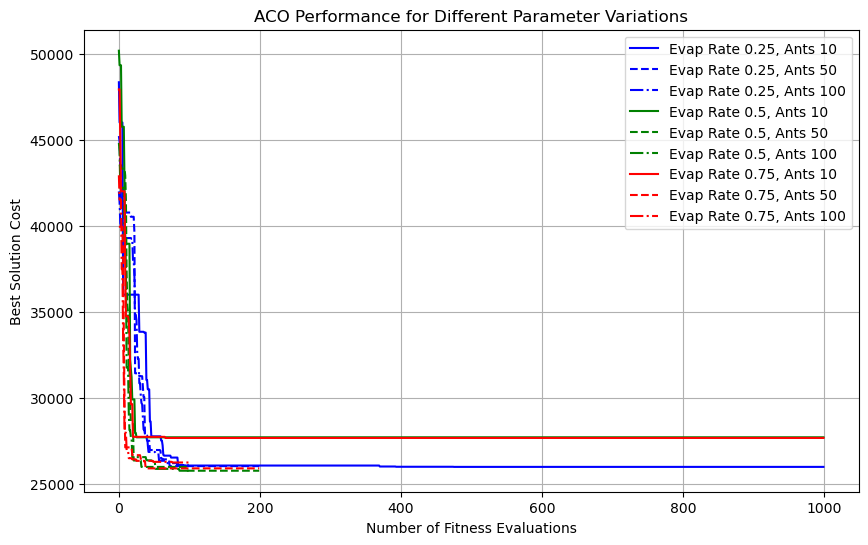

In [29]:
plt.figure(figsize=(10, 6))
for key, history in result_histories.items():
    # Extract parameters from the key
    _, evap_rate_str, _, ant_size_str = key.split('_')
    evap_rate = float(evap_rate_str)
    ant_size = int(ant_size_str)

    # Get corresponding line style and color
    line_style = line_styles[ant_size]
    color = colors[evap_rate]

    # Plot the data
    plt.plot(history, label=f'Evap Rate {evap_rate}, Ants {ant_size}', linestyle=line_style, color=color)

# Adding labels and title
plt.xlabel('Number of Fitness Evaluations')
plt.ylabel('Best Solution Cost')
plt.title('ACO Performance for Different Parameter Variations')
plt.legend()
plt.grid(True)
plt.savefig('basic_aco_performance.png')
plt.show()


In [30]:
print("Final Best Costs for Basic ACO Variants:")
for key, history in result_histories.items():
    final_best_cost = history[-1] if history else None
    print(f"{key}: {final_best_cost}")

Final Best Costs for Basic ACO Variants:
EvapRate_0.25_Ants_10: 25992.0
EvapRate_0.25_Ants_50: 26037.0
EvapRate_0.25_Ants_100: 26100.0
EvapRate_0.5_Ants_10: 27713.0
EvapRate_0.5_Ants_50: 25769.0
EvapRate_0.5_Ants_100: 25769.0
EvapRate_0.75_Ants_10: 27676.0
EvapRate_0.75_Ants_50: 25906.0
EvapRate_0.75_Ants_100: 26248.0


In [31]:
def update_pheromone_levels_mmas(pheromone_levels, ants, evaporation_rate, Q, pheromone_min, pheromone_max):
    # Initialize a delta pheromone matrix with zeros
    delta_pheromone = {i: {j: 0.0 for j in pheromone_levels[i]} for i in pheromone_levels}
    
    # Calculate the delta pheromone contributed by each ant
    for ant in ants:
        for i in range(len(ant.visited) - 1):
            current_city = ant.visited[i]
            next_city = ant.visited[i + 1]
            # Update delta pheromone for the path
            delta_pheromone[current_city][next_city] += Q / ant.total_cost
    
    # Apply pheromone evaporation to all paths
    for i in pheromone_levels:
        for j in pheromone_levels[i]:
            pheromone_levels[i][j] *= (1 - evaporation_rate)
            pheromone_levels[i][j] += delta_pheromone[i][j]
            # Apply min-max constraints
            pheromone_levels[i][j] = max(min(pheromone_levels[i][j], pheromone_max), pheromone_min)

def run_mmas_variant(distance_matrix, num_ants_variant, max_fitness_evaluations_variant, evaporation_rate_variant, Q_variant, pheromone_min_variant, pheromone_max_variant):
    best_solution_variant = None
    best_cost_variant = float('inf')
    best_cost_history_variant = []

    # Initialize pheromone levels
    pheromone_levels_variant = {
        i: {j: np.random.uniform(pheromone_min_variant, pheromone_max_variant) for j in distance_matrix[i]} for i in distance_matrix
    }

    fitness_evaluations_variant = 0
    while fitness_evaluations_variant < max_fitness_evaluations_variant:
        ants_variant = generate_ant_paths(distance_matrix, pheromone_levels_variant, num_ants_variant)
        fitness_evaluations_variant += len(ants_variant)

        for ant in ants_variant:
            if ant.total_cost < best_cost_variant:
                best_solution_variant = ant
                best_cost_variant = ant.total_cost

        best_cost_history_variant.append(best_cost_variant)
        update_pheromone_levels_mmas(pheromone_levels_variant, ants_variant, evaporation_rate_variant, Q_variant, pheromone_min_variant, pheromone_max_variant)

    return best_solution_variant, best_cost_history_variant



In [32]:
def run_mmas_with_variants(distance_matrix, max_fitness_evaluations, Q, pheromone_min, pheromone_max, evaporation_rate):
    ant_colony_sizes = [10, 50, 100]
    results_variant = {}

    for num_ants in ant_colony_sizes:
        _, best_cost_history = run_mmas_variant(distance_matrix, num_ants, max_fitness_evaluations, evaporation_rate, Q, pheromone_min, pheromone_max)
        results_variant[f"Ants_{num_ants}"] = best_cost_history
        print(f"Completed: Number of Ants = {num_ants}")

    return results_variant


In [33]:
# Parameters for MMAS Variant
alpha = 1.0
beta = 2.0
max_fitness_evaluations_variant = 10000  # Example value
Q_variant = 1.0 
pheromone_min_variant = 0.1
pheromone_max_variant = 2.0
evaporation_rate_variant = 0.5  # Example value

# Run MMAS with variant parameters
result_histories_variant = run_mmas_with_variants(distance_matrix, max_fitness_evaluations_variant, Q_variant, pheromone_min_variant, pheromone_max_variant, evaporation_rate_variant)

Completed: Number of Ants = 10
Completed: Number of Ants = 50
Completed: Number of Ants = 100


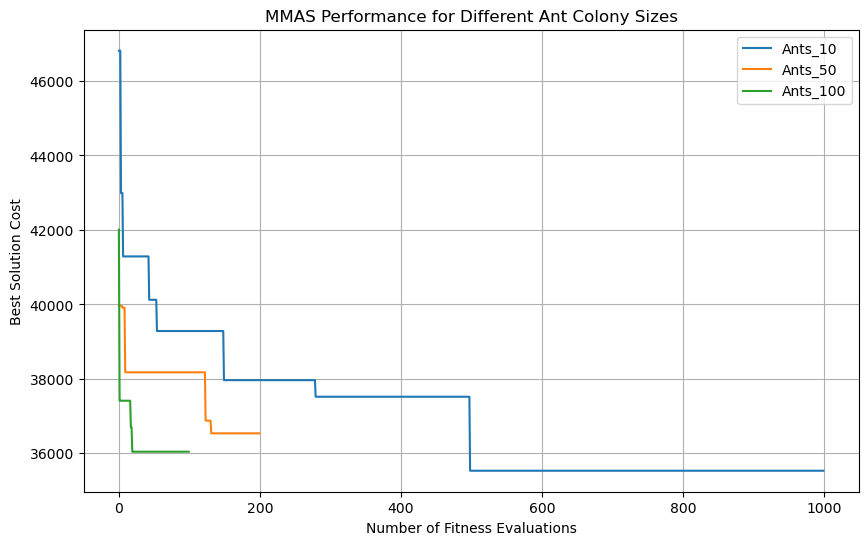

In [34]:
plt.figure(figsize=(10, 6))

for key, history in result_histories_variant.items():
    plt.plot(history, label=f'{key}')

plt.xlabel('Number of Fitness Evaluations')
plt.ylabel('Best Solution Cost')
plt.title('MMAS Performance for Different Ant Colony Sizes')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
print("Final Best Costs for MMAS ACO Variants:")
for key, history in result_histories_variant.items():
    final_best_cost = history[-1] if history else None
    print(f"{key}: {final_best_cost}")

Final Best Costs for MMAS ACO Variants:
Ants_10: 35533.0
Ants_50: 36537.0
Ants_100: 36044.0


In [36]:
def update_pheromone_levels_elitist(pheromone_levels, ants, evaporation_rate, Q, elitist_weight, best_ant):
    # Standard pheromone update
    update_pheromone_levels(pheromone_levels, ants, evaporation_rate, Q)

    # Extra pheromone for the best ant's path
    for i in range(len(best_ant.visited) - 1):
        current_city = best_ant.visited[i]
        next_city = best_ant.visited[i + 1]
        pheromone_levels[current_city][next_city] += elitist_weight / best_ant.total_cost
        
def run_elitist_aco_variant(distance_matrix, num_ants_variant, max_fitness_evaluations_variant, evaporation_rate_variant, Q_variant, elitist_weight_variant):
    best_solution_variant2 = None
    best_cost_variant2 = float('inf')
    best_cost_history_variant2 = []
    best_ant_variant2 = None

    # Initialize pheromone levels
    pheromone_levels_variant = {
        i: {j: np.random.rand() for j in distance_matrix[i]} for i in distance_matrix
    }

    fitness_evaluations_variant = 0
    while fitness_evaluations_variant < max_fitness_evaluations_variant:
        ants_variant = generate_ant_paths(distance_matrix, pheromone_levels_variant, num_ants_variant)
        fitness_evaluations_variant += len(ants_variant)

        for ant in ants_variant:
            if ant.total_cost < best_cost_variant2:
                best_solution_variant2 = ant
                best_cost_variant2 = ant.total_cost
                best_ant_variant2 = ant

        best_cost_history_variant2.append(best_cost_variant2)
        update_pheromone_levels_elitist(pheromone_levels_variant, ants_variant, evaporation_rate_variant, Q_variant, elitist_weight_variant, best_ant_variant2)

    return best_solution_variant2, best_cost_history_variant2

In [37]:
def run_elitist_aco_with_multiple_variants(distance_matrix, max_fitness_evaluations, Q, evaporation_rate):
    ant_colony_sizes = [10, 50, 100]
    elitist_weights = [2, 5, 10]
    results_elitist_variant = {}

    for num_ants in ant_colony_sizes:
        for elitist_weight in elitist_weights:
            _, best_cost_history2 = run_elitist_aco_variant(distance_matrix, num_ants, max_fitness_evaluations, evaporation_rate, Q, elitist_weight)
            key = f"Ants_{num_ants}_ElitistWeight_{elitist_weight}"
            results_elitist_variant[key] = best_cost_history2
            print(f"Completed: Number of Ants = {num_ants}, Elitist Weight = {elitist_weight}")

    return results_elitist_variant



In [38]:
# Parameters for Elitist ACO Variant
alpha = 1.0
beta = 2.0
max_fitness_evaluations_elitist_variant = 10000  # Example value
Q_elitist_variant = 1.0
evaporation_rate_elitist_variant = 0.5  # Example value

# Run Elitist ACO with multiple variants
result_histories_elitist_multiple_variants = run_elitist_aco_with_multiple_variants(distance_matrix, max_fitness_evaluations_elitist_variant, Q_elitist_variant, evaporation_rate_elitist_variant)

Completed: Number of Ants = 10, Elitist Weight = 2
Completed: Number of Ants = 10, Elitist Weight = 5
Completed: Number of Ants = 10, Elitist Weight = 10
Completed: Number of Ants = 50, Elitist Weight = 2
Completed: Number of Ants = 50, Elitist Weight = 5
Completed: Number of Ants = 50, Elitist Weight = 10
Completed: Number of Ants = 100, Elitist Weight = 2
Completed: Number of Ants = 100, Elitist Weight = 5
Completed: Number of Ants = 100, Elitist Weight = 10


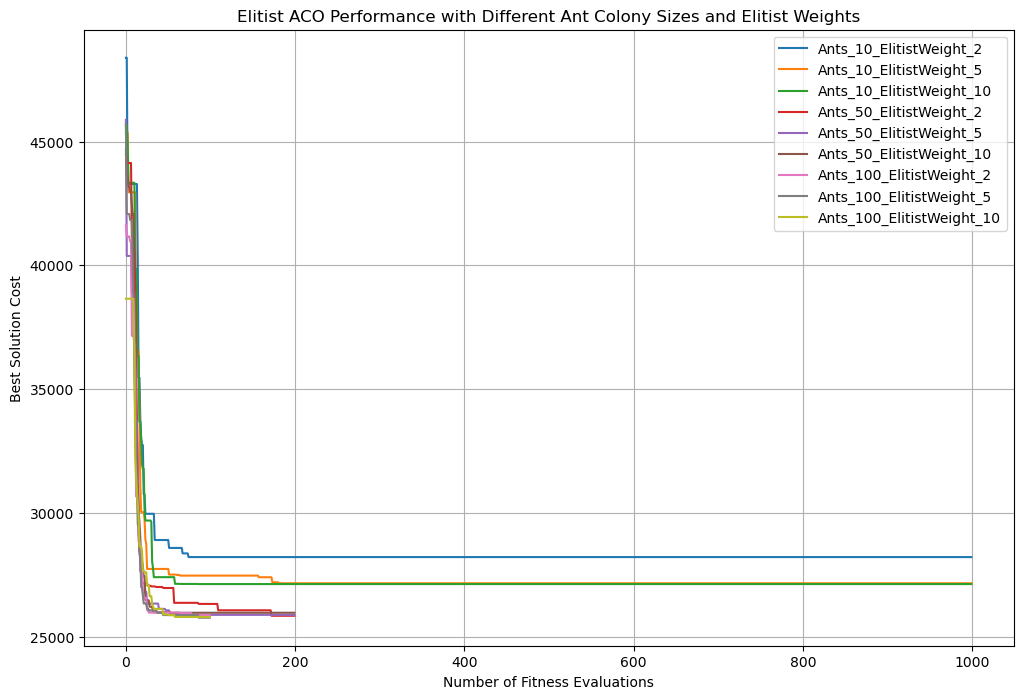

In [39]:
# Plotting
plt.figure(figsize=(12, 8))

for key, history in result_histories_elitist_multiple_variants.items():
    plt.plot(history, label=key)

plt.xlabel('Number of Fitness Evaluations')
plt.ylabel('Best Solution Cost')
plt.title('Elitist ACO Performance with Different Ant Colony Sizes and Elitist Weights')
plt.legend()
plt.grid(True)
plt.show()

In [40]:
print("Final Best Costs for Elitist ACO Variants:")
for key, history in result_histories_elitist_multiple_variants.items():
    final_best_cost = history[-1] if history else None
    print(f"{key}: {final_best_cost}")

Final Best Costs for Elitist ACO Variants:
Ants_10_ElitistWeight_2: 28218.0
Ants_10_ElitistWeight_5: 27161.0
Ants_10_ElitistWeight_10: 27128.0
Ants_50_ElitistWeight_2: 25848.0
Ants_50_ElitistWeight_5: 25884.0
Ants_50_ElitistWeight_10: 25970.0
Ants_100_ElitistWeight_2: 25876.0
Ants_100_ElitistWeight_5: 25769.0
Ants_100_ElitistWeight_10: 25799.0


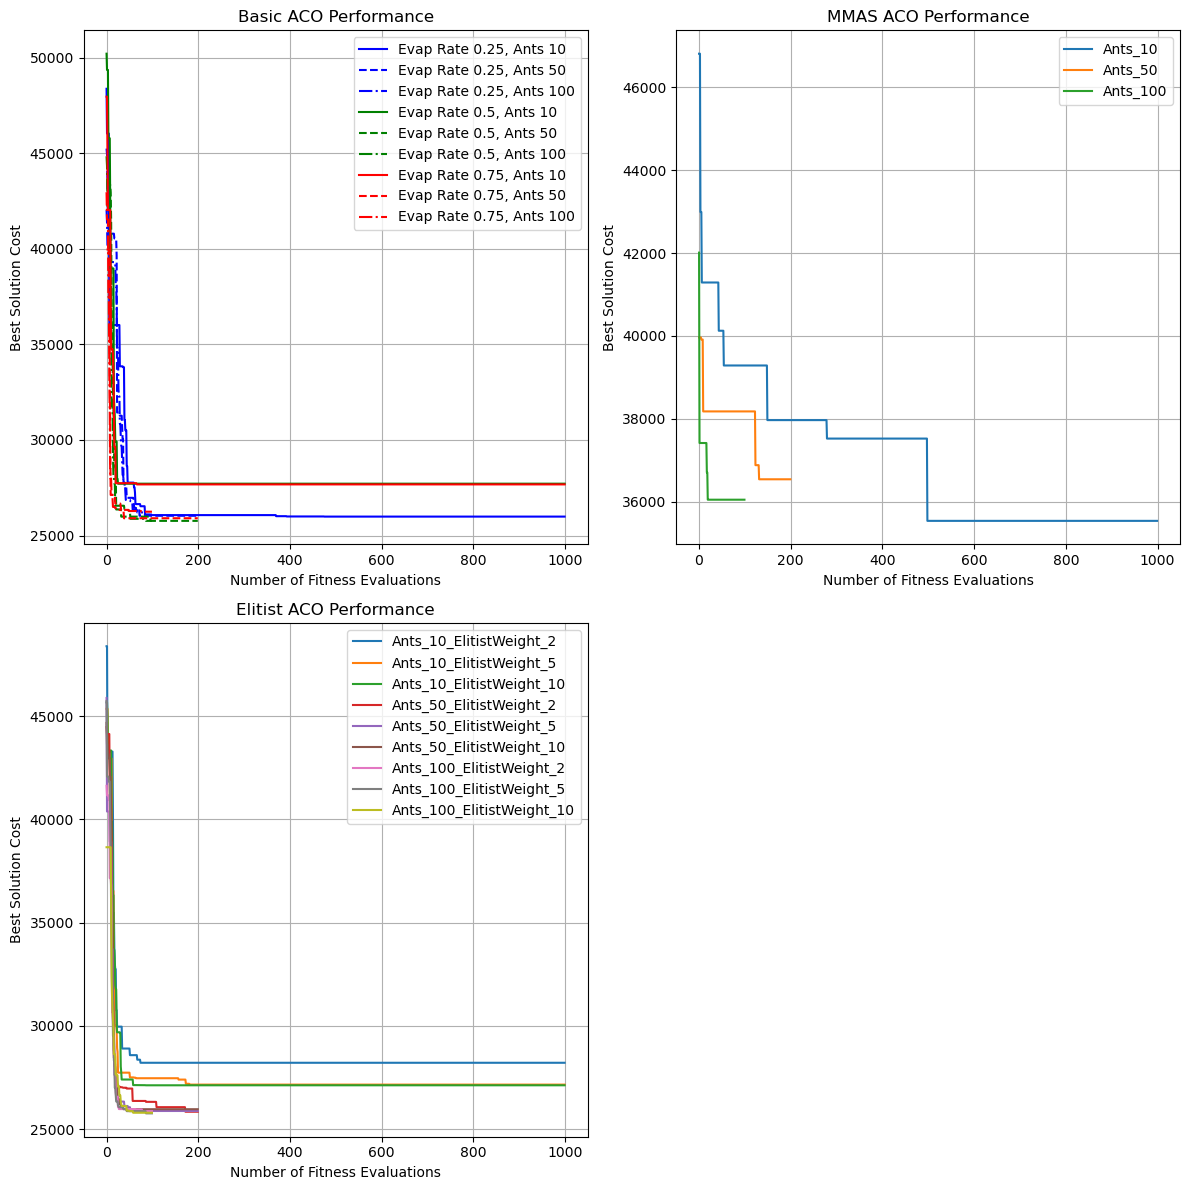

In [43]:
# Set the figure size large enough to accommodate all subplots
plt.figure(figsize=(12, 12))

# Plot for Basic ACO Variants
plt.subplot(2, 2, 1)  # First subplot in a 2x2 grid
for key, history in result_histories.items():
    _, evap_rate_str, _, ant_size_str = key.split('_')
    evap_rate = float(evap_rate_str)
    ant_size = int(ant_size_str)
    line_style = line_styles[ant_size]
    color = colors[evap_rate]
    plt.plot(history, label=f'Evap Rate {evap_rate}, Ants {ant_size}', linestyle=line_style, color=color)
plt.xlabel('Number of Fitness Evaluations')
plt.ylabel('Best Solution Cost')
plt.title('Basic ACO Performance')
plt.legend()
plt.grid(True)

# Plot for MMAS ACO Variants
plt.subplot(2, 2, 2)  # Second subplot in a 2x2 grid
for key, history in result_histories_variant.items():
    plt.plot(history, label=f'{key}')
plt.xlabel('Number of Fitness Evaluations')
plt.ylabel('Best Solution Cost')
plt.title('MMAS ACO Performance')
plt.legend()
plt.grid(True)

# Plot for Elitist ACO Variants
plt.subplot(2, 2, 3)  # Third subplot in a 2x2 grid
for key, history in result_histories_elitist_multiple_variants.items():
    plt.plot(history, label=key)
plt.xlabel('Number of Fitness Evaluations')
plt.ylabel('Best Solution Cost')
plt.title('Elitist ACO Performance')
plt.legend()
plt.grid(True)

# The fourth subplot is left empty (or you can use it for something else)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
plt.savefig('combined_aco_performance2_2x2.png')
plt.show()